# Basic template for 1D and 2D plots in qtt
### Load libraries (probably some are not needed)

In [1]:
import sys, os, tempfile
import numpy as np
%matplotlib inline
%gui qt
import matplotlib.pyplot as plt
import qcodes
from qcodes.plots.qcmatplotlib import MatPlot
from qcodes.plots.pyqtgraph import QtPlot
from qcodes.data.data_set import DataSet
import qtt
from qtt.measurements.scans import scanjob_t  
from qtt.measurements.videomode import VideoMode

import time
import datetime

In [2]:
from qtt.instrument_drivers.virtualAwg.virtual_awg import VirtualAwg
from qcodes.utils.validators import Numbers
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import ManualParameter
from qcodes import ScaledParameter

from qtt.algorithms.ohmic import fitOhmic

In [3]:
import pyvisa #Communications
import visa #Communications

In [4]:
from qtt.instrument_drivers.gates import VirtualDAC

# Drivers
from qcodes.instrument_drivers.Keysight.Keysight_34465A_submodules import Keysight_34465A
from qcodes.instrument_drivers.IST_devices.FastDuck import FastDuck as DAC_module
from qcodes_contrib_drivers.drivers.QuTech.IVVI import IVVI
from qcodes.instrument_drivers.ZI.ZIUHFLI import ZIUHFLI
#from qcodes.instrument_drivers.zurich_instruments.uhfli import UHFLI

### Choose folder to save your data

In [5]:
# set data directory
path_save = r'C:\qtt-dev\TESTS'
datadir = os.path.join(path_save, 'delete')
DataSet.default_io = qcodes.data.io.DiskIO(datadir)

In [6]:
datadir

'C:\\qtt-dev\\TESTS\\delete'

### Initialize instruments

In [7]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x2A8D::0x0101::MY57511347::INSTR',
 'ASRL1::INSTR',
 'ASRL6::INSTR',
 'ASRL10::INSTR')

In [8]:
# DMM
dmm_sensor = Keysight_34465A('dmm_sensor', 'USB0::0x2A8D::0x0101::MY57511347::INSTR')

# FAST DUCK
DAC = DAC_module('DAC','COM6', dac_step=50.0, dac_delay=0.1)

# UHFLI
#digitizer = UHFLI('digitizer','dev2148', interface='USB')
digitizer = ZIUHFLI('digitizer','dev2148')

Connected to: Keysight Technologies 34465A (serial:MY57511347, firmware:A.02.17-02.40-02.17-00.52-04-01) in 0.18s


C:\Users\Nanoelectronics\Anaconda3\envs\qtt_dev_Jaime\lib\site-packages\qcodes\utils\deprecate.py:59: QCoDeSDeprecationWarning: The class <ZIUHFLI> is deprecated, because There is a new UHFLI driver from Zurich Instruments. Use "instrument_drivers.zurich_instruments.uhfli.UHFLI" as an alternative.
  issue_deprecation_warning(f'{t} <{n}>', reason, alternative)


Discovered device `dev2148`: UHFLI with options DIG.
Creating an API session for device `dev2148` on `127.0.0.1`, `8004` with apilevel `5`.


In [9]:
from qcodes.plots.qcmatplotlib import MatPlot

def plot_dataset(dataset: DataSet, scanjob, save=True) -> None:
    """ Plot a dataset to matplotlib figure window

    Args:
        dataset: DataSet to be plotted
        scanjob: scanjob of the measurement
        save: Select if you want to save the plots

    """
    
    parameter_names = [name for name in dataset.arrays.keys() if not dataset.arrays[name].is_setpoint]
    default_array = dataset.default_parameter_array()
    
    # Path for saving
    base_loc = dataset.default_io.base_location
    folder = '\\' + dataset.location + '\\'
    label = str(scanjob.get('dataset_label'))
    path = base_loc + folder + label
    
    # 2D plots
    if len(default_array.shape) >= 2:
        for idx, parameter_name in enumerate(parameter_names):
                plot_handle = MatPlot(dataset.arrays[parameter_name], num=idx)
                plot_handle.rescale_axis()
                if save==True:
                    plt.savefig(path + str(idx) + '.png')

    # 1D plots        
    else:
        for idx, parameter_name in enumerate(parameter_names):
            plot_handle = MatPlot(dataset.arrays[parameter_name], num=idx)
            plot_handle.rescale_axis()
            if save==True:
                plt.savefig(path + str(idx) + '.png')

In [10]:
class DMM_current(qcodes.Parameter):
    def __init__(self, name, dmm_instance, gain):
        # only name is required
        super().__init__(name, label='1G',
                         #vals=qc.validators.Ints(min_value=0),
                         docstring='measures the current out of the DMM',
                         unit= 'A')
        self.dmm_instance = dmm_instance
        self._gain = gain
    # you must provide a get method, a set method, or both
    def get_raw(self):
        self._current = self.dmm_instance.volt.get()/self._gain
        return self._current
    
    def set_raw(self, val):
        # StandardParameter handles validation automatically, Parameter doesn't
        self._vals.validate(val)
        self._count = val
        


#give the parameter a name and set the gain. 
#Careful to not call it DMM.curr because it may get confused with 
#the already existing DMM 'A')

In [11]:
dmm_curr_sensor = DMM_current('dmm_curr_sensor', dmm_instance=dmm_sensor, gain=1e6)

### Settings of UHFLI

In [12]:
#UHFLI (digitizer) Scope settings - take care of all of these, for every case
#Horizontal
digitizer.scope_mode.set('Time Domain')
digitizer.scope_samplingrate.set('7.03 MHz') #'7.03 MHz', '56.2 MHz', '880 kHz', '1.80 GHz', '440 kHz', '225 MHz', '54.9 kHz', '28.1 MHz', '1.75 MHz', '113 MHz', '900 MHz', '14.0 MHz', '3.50 MHz', '220 kHz', '27.5 kHz', '450 MHz', '110 kHz'

(SR, length, dur) = (digitizer.scope_samplingrate(), digitizer.scope_length(), digitizer.scope_duration())
print('Current scope settings: SR: {}, Length: {:d}, duration: {:.6f} ({})'.format(SR, int(length), dur, digitizer.scope_duration.unit))

digitizer.scope_average_weight(1)  # Number of averages

# THE TRIG TAB
# Trigger
digitizer.scope_trig_enable.set('ON') # Trigger ON or OFF
digitizer.scope_trig_signal.set('Trig Input 1') # Channel where we want to trigger
digitizer.scope_trig_slope.set('Rise')
digitizer.scope_trig_level.set(3e-1)  # Volts if the input is volts
digitizer.scope_trig_holdoffseconds.set(2e-5)# Defines the time before the trigger is rearmed after a recording event.
digitizer.scope_trig_reference.set(0)  # Sets the reference for the delay in percent of the trace duration, i.e. 0 is at the trigger
digitizer.scope_trig_delay.set(0)  # Sets the delay for the acquisition

digitizer.scope_trig_hystmode.set('absolute') #Selects the mode to define the hysteresis strength. The relative mode will work best over the full input range as long as the analog input signal does not suffer from excessive noise.
digitizer.scope_trig_hystabsolute.set(3e-6)  # Volts if the input is volts. #Defines the voltage the source signal must deviate from the trigger level before the trigger is rearmed again. Set to 0 to turn it off. The sign is defined by the Edge setting
digitizer.scope_trig_gating_enable.set('OFF') #If enabled the trigger will be gated by the trigger gating input signal. This feature requires the DIG option
digitizer.scope_trig_gating_source.set('Trigger In 4 Low') # Select the signal source used for trigger gating if gating is enabled. This feature requires the DIG option.
digitizer.scope_trig_holdoffmode.set('s')  # QCoDeS currently does not support a holdoff in events. 

#A dict of scope readout nodes
UHFLI_read_nodes = {'Signal Input 1':0,'Signal Input 2':1,
        'Demod 1 X':2,'Demod 1 Y':3,
        'Demod 1 R':4,'Demod 1 Phase':5,'Demod 8 X':6,
        'Demod 4 X':7,'Demod 4 Y':8,
        'Demod 4 R':9,'Demod 4 Phase':10,'Demod 8 X':11,
        'Demod 8 Y':12,'Demod 8 R':13,'Demod 8 Phase':14}

Current scope settings: SR: 7.03 MHz, Length: 16384, duration: 0.002331 (s)


#### Set limits to the values of dacs (safety measure)

In [14]:
#Setting min and max values for each DAC
DAC.parameters['dac5'].vals._min_value = -1000.0
DAC.parameters['dac5'].vals._max_value = 4000.0
DAC.parameters['dac6'].vals._min_value = -500
DAC.parameters['dac6'].vals._max_value = 4000.0
DAC.parameters['dac7'].vals._min_value = -4000.0
DAC.parameters['dac7'].vals._max_value = 4000.0
DAC.parameters['dac8'].vals._min_value = -4000.0
DAC.parameters['dac8'].vals._max_value = 4000.0
DAC.parameters['dac9'].vals._min_value = -4000.0
DAC.parameters['dac9'].vals._max_value = 4000.0
DAC.parameters['dac10'].vals._min_value = -4000.0
DAC.parameters['dac10'].vals._max_value = 4000.0
DAC.parameters['dac11'].vals._min_value = 0.0
DAC.parameters['dac11'].vals._max_value = 3600.0
DAC.parameters['dac12'].vals._min_value = 0.0
DAC.parameters['dac12'].vals._max_value = 3200.0
DAC.parameters['dac13'].vals._min_value = 0.0
DAC.parameters['dac13'].vals._max_value = 4000.0
DAC.parameters['dac14'].vals._min_value = 0.0
DAC.parameters['dac14'].vals._max_value = 4000.0
DAC.parameters['dac15'].vals._min_value = 0.0
DAC.parameters['dac15'].vals._max_value = 4000.0
DAC.parameters['dac16'].vals._min_value = 0.0
DAC.parameters['dac16'].vals._max_value = 4000.0


### Give meaninful names to the gates

In [13]:
gates = VirtualDAC('gates', 
                   instruments = [DAC], 
                   gate_map ={'VCS': (0, 1), 
                              'VQD': (0, 2), 
                              'RightSeparation': (0, 3), 
                              'LeftSeparation': (0,4), 
                              'BL': (0, 5), 
                              'PM': (0, 6), 
                              'BR': (0,7), 
                              'CSL':(0,8),
                              'CSM':(0,9),
                              'CSR':(0,10)},
                   rc_times=None)

In [14]:
station = qcodes.Station(gates, DAC, dmm_curr_sensor, digitizer)

In [28]:
pv = qtt.createParameterWidget([gates])
mwindows = qtt.gui.live_plotting.setupMeasurementWindows(station, create_parameter_widget=False)
plotQ = mwindows['plotwindow']

# Find resonances

In [48]:
# I wonder what the sweeper BWmode does...
print(digitizer.sweeper_BWmode.__doc__)


                                     For each sweep point, the demodulator
                                     filter bandwidth (time constant) may
                                     be either set automatically, be the
                                     current demodulator bandwidth or be
                                     a fixed number; the sweeper_BW
                                     parameter.
                                     

Parameter class:

* `name` sweeper_BWmode
* `label` Sweeper bandwidth control mode
* `unit` 
* `vals` <Enum: {'auto', 'current', 'fixed'}>


In [73]:
# Set up a sweep sweeping an internal oscillator frequency from 1 MHz to 5 MHz
# We want the sweeper to sweep linearly over 200 points
digitizer.sweeper_param('Osc 1 Frequency')
digitizer.sweeper_xmapping('lin')
digitizer.sweeper_start(11e6)
digitizer.sweeper_stop(20e6)
digitizer.sweeper_samplecount(100)
digitizer.sweeper_BWmode('fixed')
digitizer.sweeper_BW(250)
digitizer.sweeper_order(4)

# Signal to be measured
digitizer.add_signal_to_sweeper(4, 'R')

# Make sure that demodulator 4 is measuring what and as it should
digitizer.demod4_trigger('Continuous')
digitizer.demod4_signalin('Sig In 1')

# Make sweeper ready to measure.
digitizer.Sweep.build_sweep()

# I wonder what kind of sweep we have made now...
digitizer.print_sweeper_settings()

DataSet:
   location = '2021-03-04/17-49-04_qtt_generic'
   <Type>   | <array_id>  | <array.name> | <array.shape>
   Setpoint | Hz_set      | Hz           | (100,)
   Measured | digitizer_R | R            | (100,)
acquired at 2021-03-04 17:49:07


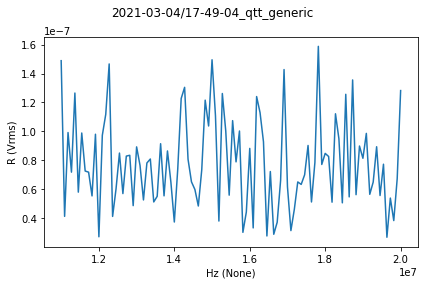

In [75]:
from qcodes.measure import Measure
# Perform a proper QCoDeS measurement
sweepdata = Measure(digitizer.Sweep).run()
plot_dataset(sweepdata, scanjob, save=True)

# Optimize amplitude

scan2D: 0/5: time 00:00:00 (~00:00:00 remaining): setting CSR to 0.000


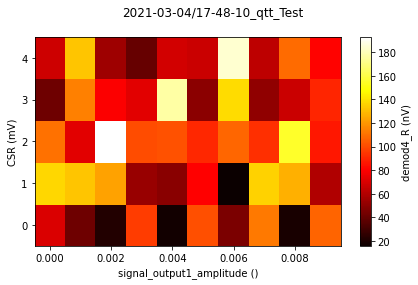

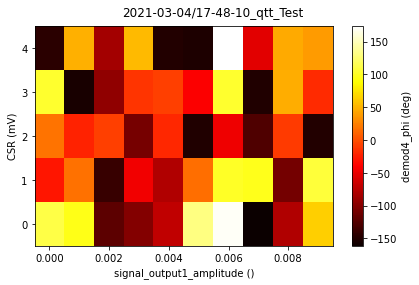

In [71]:
# Prepare digitizer
station.digitizer.oscillator1_freq(10e6)
station.digitizer.signal_output1_on('ON') # Turn on oscillator


scanjob = scanjob_t({'sweepdata': dict({'param': digitizer.signal_output1_amplitude, 
                                        'start': 0.0, 'end': 0.010, 'step':0.001}), 
                     'minstrument': [station.digitizer.demod4_R, station.digitizer.demod4_phi], 'wait_time': 1e-3})

scanjob['stepdata'] = dict({'param': station.gates.CSR, 'start': 0.0, 'end': 5.0, 'step': 1})
scanjob['dataset_label'] = 'Test'

data = qtt.measurements.scans.scan2D(station, scanjob, liveplotwindow=None, diff_dir=None, location = None, update_period=1)
# Turn off oscillator
station.digitizer.signal_output1_on('OFF')

plot_dataset(data, scanjob, save=True)

# Optimize frequency

scan2D: 0/5: time 00:00:00 (~00:00:00 remaining): setting CSR to 0.000


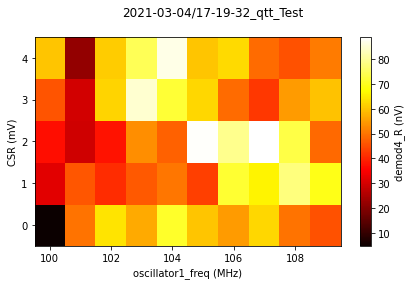

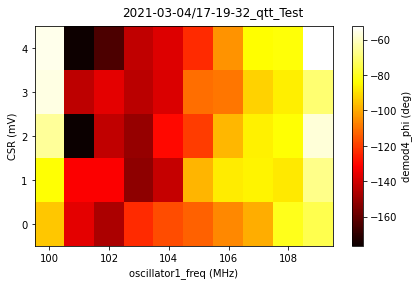

In [44]:
# Prepare digitizer
station.digitizer.signal_output1_amplitude(1e-3)
station.digitizer.signal_output1_on('ON') # Turn on oscillator

scanjob = scanjob_t({'sweepdata': dict({'param': digitizer.oscillator1_freq, 
                                        'start': 100.0e6, 'end': 110.0e6, 'step':1e6}), 
                     'minstrument': [station.digitizer.demod4_R, station.digitizer.demod4_phi], 'wait_time': 1e-3})

scanjob['stepdata'] = dict({'param': station.gates.CSR, 'start': 0.0, 'end': 5.0, 'step': 1})
scanjob['dataset_label'] = 'Test'

data = qtt.measurements.scans.scan2D(station, scanjob, liveplotwindow=None, diff_dir=None, location = None, update_period=1)
# Turn off oscillator
station.digitizer.signal_output1_on('OFF')

plot_dataset(data, scanjob, save=True)